In [1]:
%cd 'drive/My Drive/BioMedical/HW1'

/content/drive/My Drive/BioMedical/HW1


In [2]:
!pip install nibabel -q
!pip install nilearn -q
!pip install bm3d -q


In [21]:
# IMPORTS
import nibabel as nib
import numpy as np
from nilearn.image import resample_img
import matplotlib.pyplot as plt

import bm3d
from scipy import stats
from skimage.restoration import denoise_nl_means , estimate_sigma , denoise_tv_chambolle 
from skimage.filters import gaussian , median

import cv2

################################### load images
def load_img(path):
    img = nib.load(path)
    data = img.get_fdata() # get array    
    data *= 255.0/data.max()
    data = data.astype(np.float64)
    return data

################################### get slices 

def get_slices(img, idx1 , idx2 , idx3):
    slice_0 = img[idx1, :, :]
    slice_1 = img[:, idx2, :]
    slice_2 = img[:, :, idx3]
    return slice_0, slice_1, slice_2

################################### show slices

def show_slices(slices , title):
    fig, axes = plt.subplots(2, 3, linewidth =5  ,edgecolor="yellow" , figsize = (10 , 18) , facecolor = "white")
    fig.suptitle(title , fontsize = 15 , color = "red")  
    fig.tight_layout()
    plt.subplots_adjust(bottom=0.5) 
    
    slice_label = ['Clear' , 'Noisy' , 'BM3D' , 'BM3D VST' , 'NLM'  , "PSNLM"]
    k = 0
    for i in range(2):
        for j in range(3):
            slice = slices[k]
            axes[i , j].imshow(slice, cmap="gray", origin="lower") 
            axes[i , j].set_title(slice_label[k])
            k+=1

################################### denoising algorithm 1: BM3D
def denoising_BM3D(img , psd ):
    denoised = bm3d.bm3d(img, sigma_psd=psd, stage_arg=bm3d.BM3DStages.ALL_STAGES)
    return denoised



def denoising_BM3D_VST(img , psd ):
    img = VST(img) 
    denoised =  inverse_VST(bm3d.bm3d(img, sigma_psd=psd, stage_arg=bm3d.BM3DStages.ALL_STAGES))
    return denoised


################################## denoising algorithm 2: NLM
def denoising_NLM(img , psd):

    return denoise_nl_means(img , h = 1.15 * psd, fast_mode = True, patch_size = 5, patch_distance = 3)


def denoising_PSNLM(img  , psd):
    img = VST2(img )
    filtered_img = median(img)
    return  VST2(denoise_nl_means(filtered_img , h =  psd, fast_mode = True, patch_size = 2, patch_distance = 3))



################################### get SNR & PSNR

def SNR(clear , noisy ): 
    m = clear.mean()
    noise = noisy - clear
    sd = noise.std()
    return  m / sd

def PSNR(original, denoised): 
    mse = np.mean((original - denoised) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse)) 
    return psnr 

################################## Perform VST unsing Anscombe transform

def VST(img):
    return 2* np.sqrt(img + 3/8)

def inverse_VST(img):
    inv =  ((img * 0.5)**2) - 3/8
    return inv
################################## CLAHE
def CLAHE(img):
    image_bw = img.astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit = 2) 
    final_img = clahe.apply(image_bw)
    final_img = final_img.astype(np.float64)

    return final_img 

################################## perform VST2 using squared magnitude

def VST2(img ):
    img = np.abs(img)
    z2 = img**2 
    b = img[-20:][:20]
    s2 = np.sqrt(b.mean()/2)
    SM = z2 - s2
    SM = np.where (SM < 0 , 0 , np.sqrt(SM))
    return SM


In [4]:
# read images
T1_Clear = load_img("t1_icbm_normal_1mm_pn0_rf0.mnc")
T1_Noisy = load_img("t1_icbm_normal_1mm_pn9_rf40.mnc")
T2_Clear = load_img("t2_icbm_normal_1mm_pn0_rf0.mnc")
T2_Noisy = load_img("t2_icbm_normal_1mm_pn9_rf40.mnc")
PD_Clear = load_img("pd_icbm_normal_1mm_pn0_rf0.mnc")
PD_Noisy = load_img("pd_icbm_normal_1mm_pn9_rf40.mnc")

In [ ]:
# Denoising T1
T1_denoised1 = denoising_BM3D(T1_Noisy , psd = 15)
T1_denoised2 = denoising_BM3D_VST(T1_Noisy , psd = 1.8)
T1_denoised3 = denoising_NLM(T1_Noisy , psd = 8)
T1_denoised4 = denoising_PSNLM(T1_Noisy , psd = 0.1)

In [23]:
# Show sample slices
T1_Clear_slice0 , T1_Clear_slice1 , T1_Clear_slice2 = get_slices(T1_Clear , 90 ,  100 , 90)
T1_Noisy_slice0 , T1_Noisy_slice1 , T1_Noisy_slice2 = get_slices(T1_Noisy , 90 ,  100 , 90)
T1_denoised1_slice0 , T1_denoised1_slice1 , T1_denoised1_slice2 = get_slices(T1_denoised1 , 90 ,  100 , 90)
T1_denoised2_slice0 , T1_denoised2_slice1 , T1_denoised2_slice2 = get_slices(T1_denoised2 , 90 ,  100 , 90)
T1_denoised3_slice0 , T1_denoised3_slice1 , T1_denoised3_slice2 = get_slices(T1_denoised3 , 90 ,  100 , 90)
T1_denoised4_slice0 , T1_denoised4_slice1 , T1_denoised4_slice2 = get_slices(T1_denoised4 , 90 ,  100 , 90)

T1_denoised2_slice0 = CLAHE(T1_denoised2_slice0)
T1_denoised2_slice1 = CLAHE(T1_denoised2_slice1)
T1_denoised2_slice2 = CLAHE(T1_denoised2_slice2)


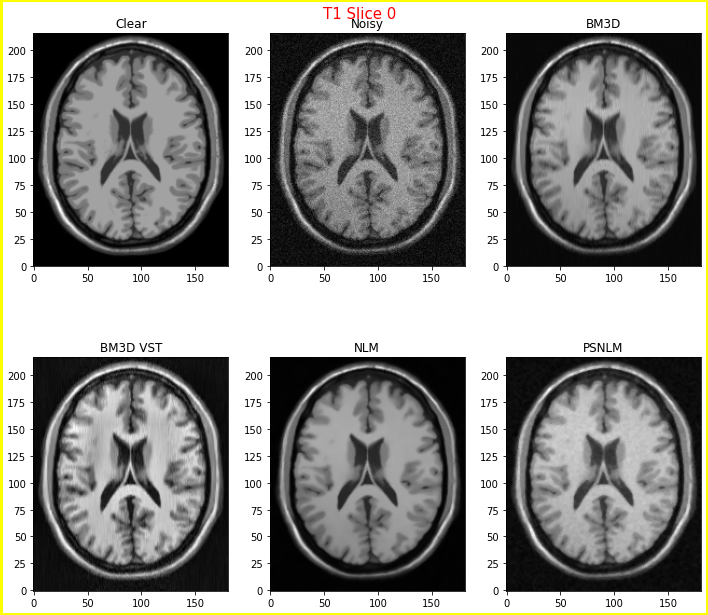

In [24]:
show_slices([T1_Clear_slice0, T1_Noisy_slice0, T1_denoised1_slice0 , T1_denoised2_slice0 ,T1_denoised3_slice0 ,T1_denoised4_slice0 ] , "T1 Slice 0")


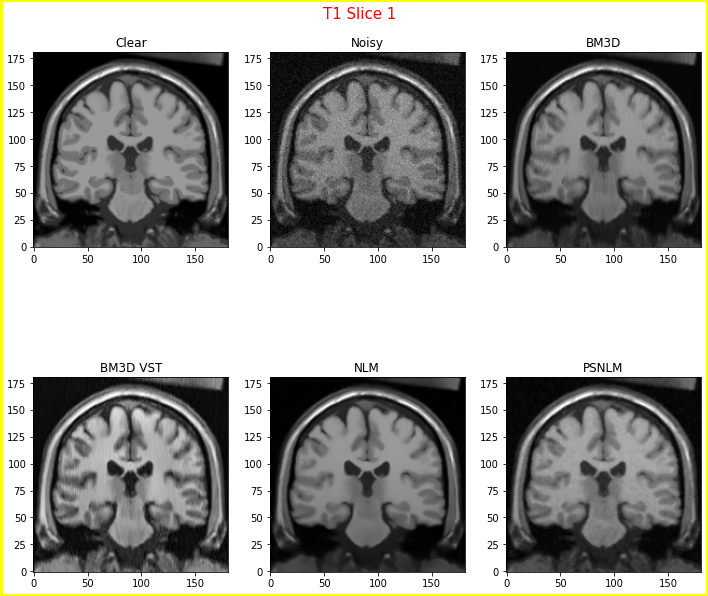

In [25]:
show_slices([T1_Clear_slice1, T1_Noisy_slice1, T1_denoised1_slice1 , T1_denoised2_slice1 , T1_denoised3_slice1 , T1_denoised4_slice1] , "T1 Slice 1")

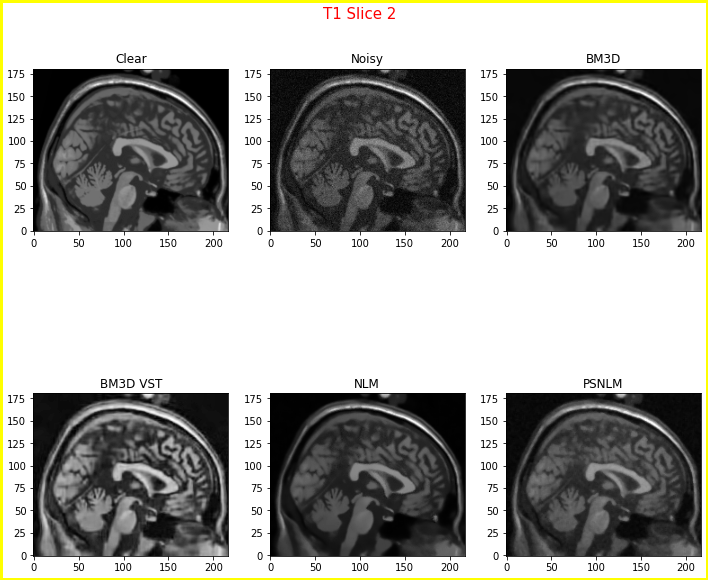

In [26]:
show_slices([T1_Clear_slice2, T1_Noisy_slice2, T1_denoised1_slice2 , T1_denoised2_slice2 , T1_denoised3_slice2 , T1_denoised4_slice2] , "T1 Slice 2")

In [27]:
print("SNR Noisy: " ,  SNR(T1_Clear_slice0 , T1_Noisy_slice0))
print("SNR BM3D Basic: " ,  SNR(T1_Clear_slice0 , T1_denoised1_slice0))
print("SNR BM3D VST: " ,  SNR(T1_Clear_slice0 , T1_denoised2_slice0))
print("SNR NLM: " ,  SNR(T1_Clear_slice0 , T1_denoised3_slice0))
print("SNR PSNLM: " ,  SNR(T1_Clear_slice0 , T1_denoised4_slice0))


SNR Noisy:  3.8696352445622577
SNR BM3D Basic:  4.208815681885636
SNR BM3D VST:  5.370048883094523
SNR NLM:  4.195638991910656
SNR PSNLM:  4.133518940478593


In [ ]:
# Denoising T2
T2_denoised1 = denoising_BM3D(T2_Noisy , psd = 15)
T2_denoised2 = denoising_BM3D_VST(T2_Noisy , psd = 2)
T2_denoised3 = denoising_NLM(T2_Noisy , psd = 8)
T2_denoised4 = denoising_PSNLM(T2_Noisy , psd = 0.5)

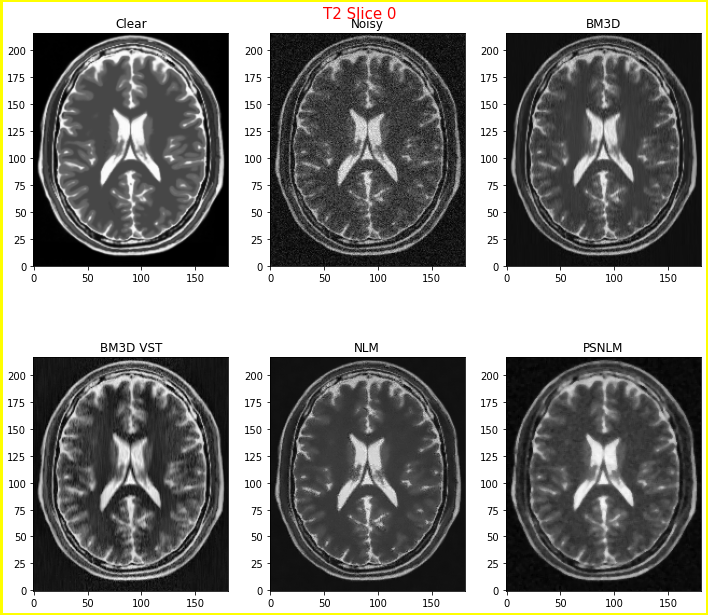

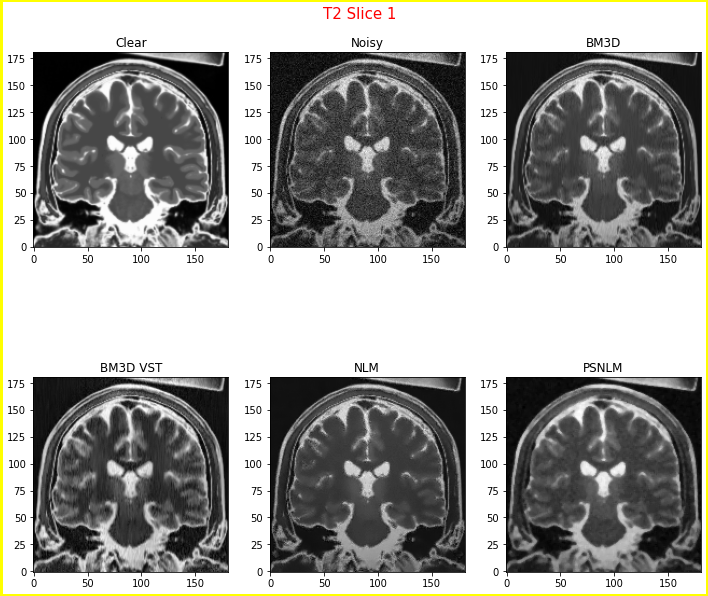

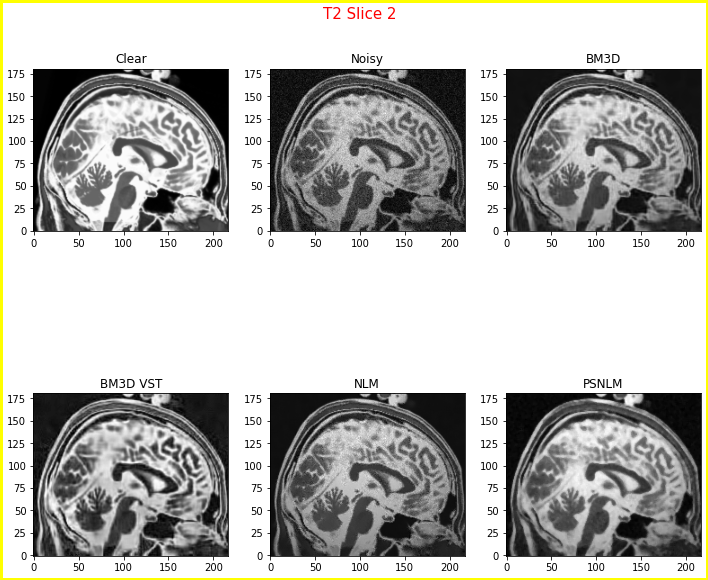

In [40]:
# Show sample slices
T2_Clear_slice0 , T2_Clear_slice1 , T2_Clear_slice2 = get_slices(T2_Clear , 90 ,  100 , 90)
T2_Noisy_slice0 , T2_Noisy_slice1 , T2_Noisy_slice2 = get_slices(T2_Noisy , 90 ,  100 , 90)
T2_denoised1_slice0 , T2_denoised1_slice1 , T2_denoised1_slice2 = get_slices(T2_denoised1 , 90 ,  100 , 90)
T2_denoised2_slice0 , T2_denoised2_slice1 , T2_denoised2_slice2 = get_slices(T2_denoised2 , 90 ,  100 , 90)
T2_denoised3_slice0 , T2_denoised3_slice1 , T2_denoised3_slice2 = get_slices(T2_denoised3 , 90 ,  100 , 90)
T2_denoised4_slice0 , T2_denoised4_slice1 , T2_denoised4_slice2 = get_slices(T2_denoised4 , 90 ,  100 , 90)

T2_denoised2_slice0 = CLAHE(T2_denoised2_slice0)
T2_denoised2_slice1 = CLAHE(T2_denoised2_slice1)
T2_denoised2_slice2 = CLAHE(T2_denoised2_slice2)


show_slices([T2_Clear_slice0, T2_Noisy_slice0, T2_denoised1_slice0 , T2_denoised2_slice0 , T2_denoised3_slice0 , T2_denoised4_slice0] , "T2 Slice 0")
show_slices([T2_Clear_slice1, T2_Noisy_slice1, T2_denoised1_slice1 , T2_denoised2_slice1 , T2_denoised3_slice1 , T2_denoised4_slice1] , "T2 Slice 1")
show_slices([T2_Clear_slice2, T2_Noisy_slice2, T2_denoised1_slice2 , T2_denoised2_slice2 , T2_denoised3_slice2 , T2_denoised4_slice2] , "T2 Slice 2")


In [41]:
print("T2 Noisy: " ,  SNR(T2_Clear_slice0 , T2_Noisy_slice0))
print("T2 BM3D Basic: " ,  SNR(T2_Clear_slice0 , T2_denoised1_slice0))
print("T2 BM3D VST: " ,  SNR(T2_Clear_slice0 , T2_denoised2_slice0))
print("T2 NLM: " ,  SNR(T2_Clear_slice0 , T2_denoised3_slice0))
print("T2 PSNLM: " ,  SNR(T2_Clear_slice0 , T2_denoised4_slice0))

T2 Noisy:  2.381235678155643
T2 BM3D Basic:  2.5101425635084764
T2 BM3D VST:  3.6980734982937666
T2 NLM:  2.5101018476260784
T2 PSNLM:  2.2824986118128385


In [67]:
# Denoising PD
PD_denoised1 = denoising_BM3D(PD_Noisy , psd = 12)
PD_denoised2 = denoising_BM3D_VST(PD_Noisy , psd =1.5)
PD_denoised3 = denoising_NLM(PD_Noisy , psd = 9)
PD_denoised4 = denoising_PSNLM(PD_Noisy , psd = 0.5)

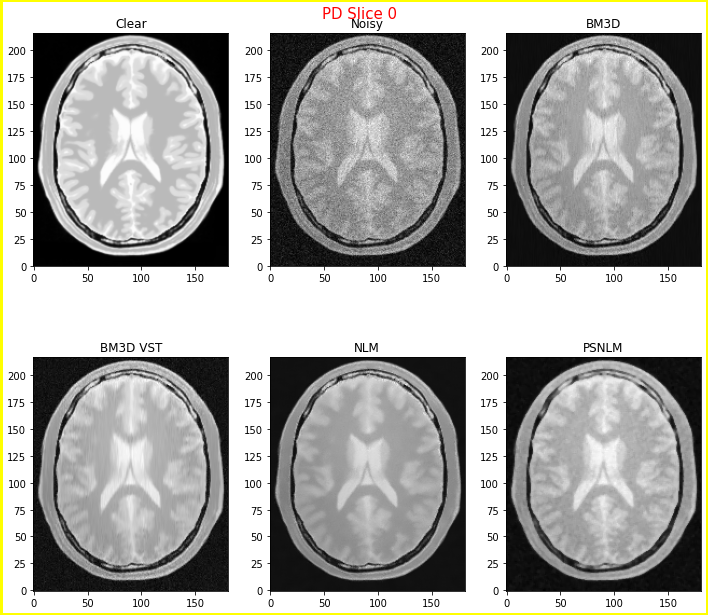

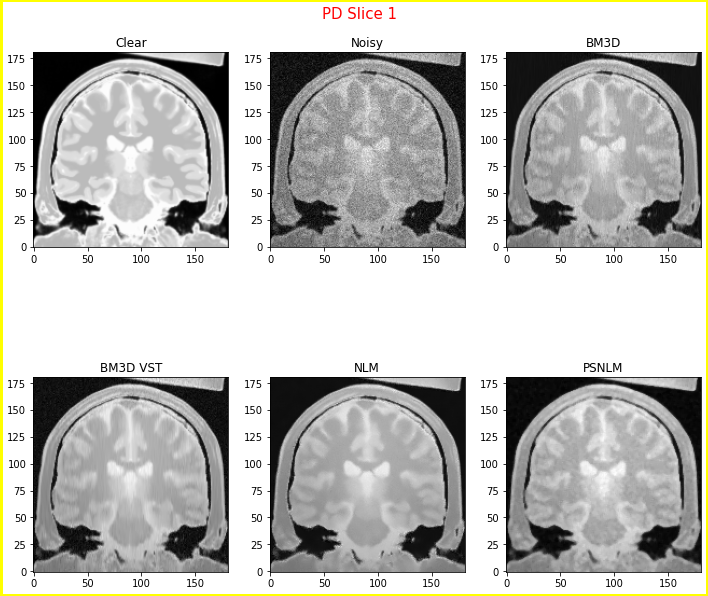

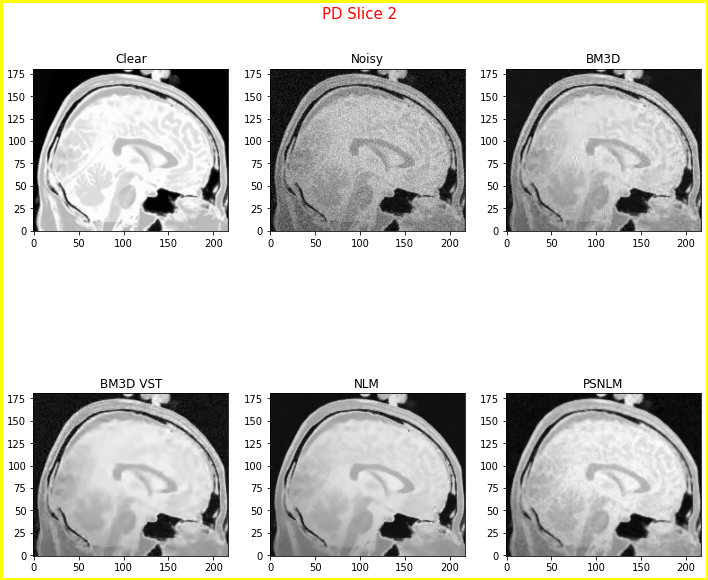

In [70]:
# Show sample slices
PD_Clear_slice0 , PD_Clear_slice1 , PD_Clear_slice2 = get_slices(PD_Clear , 90 ,  100 , 90)
PD_Noisy_slice0 , PD_Noisy_slice1 , PD_Noisy_slice2 = get_slices(PD_Noisy , 90 ,  100 , 90)
PD_denoised1_slice0 , PD_denoised1_slice1 , PD_denoised1_slice2 = get_slices(PD_denoised1 , 90 ,  100 , 90)
PD_denoised2_slice0 , PD_denoised2_slice1 , PD_denoised2_slice2 = get_slices(PD_denoised2 , 90 ,  100 , 90)
PD_denoised3_slice0 , PD_denoised3_slice1 , PD_denoised3_slice2 = get_slices(PD_denoised3 , 90 ,  100 , 90)
PD_denoised4_slice0 , PD_denoised4_slice1 , PD_denoised4_slice2 = get_slices(PD_denoised4 , 90 ,  100 , 90)


#PD_denoised2_slice0 = CLAHE(PD_denoised2_slice0)
#PD_denoised2_slice1 = CLAHE(PD_denoised2_slice1)
#PD_denoised2_slice2 = CLAHE(PD_denoised2_slice2)

show_slices([PD_Clear_slice0, PD_Noisy_slice0, PD_denoised1_slice0 , PD_denoised2_slice0 ,PD_denoised3_slice0, PD_denoised4_slice0] , "PD Slice 0")
show_slices([PD_Clear_slice1, PD_Noisy_slice1, PD_denoised1_slice1 , PD_denoised2_slice1 ,PD_denoised3_slice1, PD_denoised4_slice1] , "PD Slice 1")
show_slices([PD_Clear_slice2, PD_Noisy_slice2, PD_denoised1_slice2 , PD_denoised2_slice2 ,PD_denoised3_slice2, PD_denoised4_slice2] , "PD Slice 2")


In [71]:
print("PD Noisy: " ,  SNR(PD_Clear_slice0 , PD_Noisy_slice0))
print("PD BM3D Basic: " ,  SNR(PD_Clear_slice0 , PD_denoised1_slice0))
print("SNR BM3D VST: " ,  SNR(PD_Clear_slice0 , PD_denoised2_slice0))
print("SNR NLM: " ,  SNR(PD_Clear_slice0 , PD_denoised3_slice0))
print("SNR PSNLM: " ,  SNR(PD_Clear_slice0 , PD_denoised4_slice0))


PD Noisy:  3.792568859886844
PD BM3D Basic:  4.017792676722739
SNR BM3D VST:  4.035713875155589
SNR NLM:  4.009556217519811
SNR PSNLM:  3.937408452913319
